In [1]:
import os
from pathlib import Path
import pandas as pd
import xlsxwriter

In [2]:
transfers_prefix = "s3://<bucket-name>"
transfer_files = [
    "transfers-Sept-2020.json",
    "transfers-Oct-2020.json",
    "transfers-Nov-2020.json",
    "transfers-Dec-2020.json",
    "transfers-Jan-2021.json"
]
transfer_input_files = [transfers_prefix + f for f in transfer_files]
asid_lookup_file = transfers_prefix + "asidLookup.csv"

In [3]:
asid_lookup = pd.read_csv(asid_lookup_file)

In [4]:
date_cols = ["dateRequested", "dateCompleted"]
transfers = pd.concat((
    pd.read_json(f, convert_dates=date_cols)
    for f in transfer_input_files
))

In [5]:
supplier_transfers = transfers\
    .merge(asid_lookup, left_on='requestingPracticeAsid',right_on='ASID',how='left')\
    .merge(asid_lookup, suffixes=('_requesting', '_sending'), left_on='sendingPracticeAsid',right_on='ASID',how='left')\

supplier_transfers["MName_sending"] = supplier_transfers["MName_sending"].fillna("Unknown")
supplier_transfers["MName_requesting"] = supplier_transfers["MName_requesting"].fillna("Unknown")

In [6]:
supplier_transfers["MName_sending"].value_counts(dropna=False)

EGTON MEDICAL INFORMATION SYSTEMS LTD (EMIS)    875743
THE PHOENIX PARTNERSHIP                         203366
IN PRACTICE SYSTEMS LTD                          24760
Unknown                                           3813
MICROTEST LTD                                      995
Name: MName_sending, dtype: int64

In [7]:
monthy_transfer_breakdown_by_supplier_pathways = supplier_transfers[
    ["dateRequested", "MName_requesting", "MName_sending", "status"]
].pivot_table(
    index=[
        supplier_transfers["dateRequested"].dt.year,
        supplier_transfers["dateRequested"].dt.month,
        "MName_requesting",
        "MName_sending"
    ],
    columns=["status"],
    aggfunc=len,
    fill_value=0
)
monthy_transfer_breakdown_by_supplier_pathways

dateRequested  \
status                                                                                                                TransferStatus.FAILED   
dateRequested dateRequested MName_requesting                             MName_sending                                                        
2020          9             EGTON MEDICAL INFORMATION SYSTEMS LTD (EMIS) EGTON MEDICAL INFORMATION SYSTEMS LTD (EMIS)                  2053   
                                                                         IN PRACTICE SYSTEMS LTD                                         58   
                                                                         MICROTEST LTD                                                   48   
                                                                         THE PHOENIX PARTNERSHIP                                       4207   
                                                                         Unknown                                                        104   
...                                                                                                                                     ...   
2021          1             THE PHOENIX PARTNERSHIP                      MICROTEST LTD                                                   59   
                                                                         THE PHOENIX PARTNERSHIP                                         17   
                                                                         Unknown                                                          5   
                            Unknown                                      EGTON MEDICAL INFORMATION SYSTEMS LTD (EMIS)                     0   
                                                                         THE PHOENIX PARTNERSHIP                                         27   

                                                                                                                                                 \
status                                                                                                                TransferStatus.INTEGRATED   
dateRequested dateRequested MName_requesting                             MName_sending                                                            
2020          9             EGTON MEDICAL INFORMATION SYSTEMS LTD (EMIS) EGTON MEDICAL INFORMATION SYSTEMS LTD (EMIS)                    151960   
                                                                         IN PRACTICE SYSTEMS LTD                                           2727   
                                                                         MICROTEST LTD                                                       18   
                                                                         THE PHOENIX PARTNERSHIP                                          47232   
                                                                         Unknown                                                            878   
...                                                                                                                                         ...   
2021          1             THE PHOENIX PARTNERSHIP                      MICROTEST LTD                                                        5   
                                                                         THE PHOENIX PARTNERSHIP                                              0   
                                                                         Unknown                                                             26   
                            Unknown                                      EGTON MEDICAL INFORMATION SYSTEMS LTD (EMIS)                        46   
                                                                         THE PHOENIX PARTNERSHIP                                             23   

                                                                

In [8]:
EMIS_name = "EGTON MEDICAL INFORMATION SYSTEMS LTD (EMIS)"
EMIS_monthly_transfer_breakdown = monthy_transfer_breakdown_by_supplier_pathways.iloc[monthy_transfer_breakdown_by_supplier_pathways.index.get_level_values('MName_requesting') == EMIS_name]
EMIS_monthly_transfer_breakdown=EMIS_monthly_transfer_breakdown['dateRequested']

In [9]:
EMIS_monthly_transfer_breakdown.div(EMIS_monthly_transfer_breakdown.sum(axis=1),axis=0)*100

status                                                                                                                 TransferStatus.FAILED  \
dateRequested dateRequested MName_requesting                             MName_sending                                                         
2020          9             EGTON MEDICAL INFORMATION SYSTEMS LTD (EMIS) EGTON MEDICAL INFORMATION SYSTEMS LTD (EMIS)               1.311310   
                                                                         IN PRACTICE SYSTEMS LTD                                    1.271372   
                                                                         MICROTEST LTD                                             39.024390   
                                                                         THE PHOENIX PARTNERSHIP                                    7.959060   
                                                                         Unknown                                                   10.216110   
              10            EGTON MEDICAL INFORMATION SYSTEMS LTD (EMIS) EGTON MEDICAL INFORMATION SYSTEMS LTD (EMIS)               1.433007   
                                                                         IN PRACTICE SYSTEMS LTD                                    1.007625   
                                                                         MICROTEST LTD                                             16.379310   
                                                                         THE PHOENIX PARTNERSHIP                                    8.693994   
                                                                         Unknown                                                    6.314244   
              11            EGTON MEDICAL INFORMATION SYSTEMS LTD (EMIS) EGTON MEDICAL INFORMATION SYSTEMS LTD (EMIS)               1.324219   
                                                                         IN PRACTICE SYSTEMS LTD                                    0.534938   
                                                                         MICROTEST LTD                                             19.266055   
                                                                         THE PHOENIX PARTNERSHIP                                    9.573137   
                                                                         Unknown                                                    5.535055   
              12            EGTON MEDICAL INFORMATION SYSTEMS LTD (EMIS) EGTON MEDICAL INFORMATION SYSTEMS LTD (EMIS)               1.191558   
                                                                         IN PRACTICE SYSTEMS LTD                                    0.903023   
                                                                         MICROTEST LTD                                             28.985507   
                                                                         THE PHOENIX PARTNERSHIP                                   10.425979   
                                                                         Unknown                                                    5.747126   
2021          1             EGTON MEDICAL INFORMATION SYSTEMS LTD (EMIS) EGTON MEDICAL INFORMATION SYSTEMS LTD (EMIS)               1.435048   
                                                                         IN PRACTICE SYSTEMS LTD                                    1.580278   
                                                                         MICROTEST LTD                                             37.333333   
                                                                         THE PHOENIX PARTNERSHIP                                    9.197473   
                                                                         Unknown                                                    1.408451   

status                                                                                                         

In [10]:
import paths, data
response_codes = pd.read_csv(data.gp2gp_response_codes.path)
supplier_transfers = supplier_transfers.merge(response_codes, left_on='finalErrorCode',right_on='ErrorCode',how='left')

In [11]:
final_errors_per_suplier_path = supplier_transfers[
    ["MName_requesting", "MName_sending", "finalErrorCode"]
].pivot_table(
    index=[
        "MName_requesting", "MName_sending",
    ],
    columns=["finalErrorCode"],
    aggfunc=len,
    fill_value=0
)
final_errors_per_suplier_path

finalErrorCode                                                                             9.0   \
MName_requesting                             MName_sending                                        
EGTON MEDICAL INFORMATION SYSTEMS LTD (EMIS) EGTON MEDICAL INFORMATION SYSTEMS LTD (EMIS)     0   
                                             IN PRACTICE SYSTEMS LTD                          0   
                                             MICROTEST LTD                                    0   
                                             THE PHOENIX PARTNERSHIP                          0   
                                             Unknown                                          0   
IN PRACTICE SYSTEMS LTD                      EGTON MEDICAL INFORMATION SYSTEMS LTD (EMIS)     1   
                                             IN PRACTICE SYSTEMS LTD                          0   
                                             THE PHOENIX PARTNERSHIP                          0   
MICROTEST LTD                                EGTON MEDICAL INFORMATION SYSTEMS LTD (EMIS)     0   
                                             THE PHOENIX PARTNERSHIP                          0   
THE PHOENIX PARTNERSHIP                      EGTON MEDICAL INFORMATION SYSTEMS LTD (EMIS)     4   
                                             IN PRACTICE SYSTEMS LTD                          0   
                                             Unknown                                          0   
Unknown                                      EGTON MEDICAL INFORMATION SYSTEMS LTD (EMIS)     0   
                                             IN PRACTICE SYSTEMS LTD                          0   
                                             THE PHOENIX PARTNERSHIP                          0   
                                             Unknown                                          0   

finalErrorCode                                                                             11.0  \
MName_requesting                             MName_sending                                        
EGTON MEDICAL INFORMATION SYSTEMS LTD (EMIS) EGTON MEDICAL INFORMATION SYSTEMS LTD (EMIS)   240   
                                             IN PRACTICE SYSTEMS LTD                          9   
                                             MICROTEST LTD                                    0   
                                             THE PHOENIX PARTNERSHIP                         64   
                                             Unknown                                          1   
IN PRACTICE SYSTEMS LTD                      EGTON MEDICAL INFORMATION SYSTEMS LTD (EMIS)    57   
                                             IN PRACTICE SYSTEMS LTD                          0   
                                             THE PHOENIX PARTNERSHIP                          8   
MICROTEST LTD                                EGTON MEDICAL INFORMATION SYSTEMS LTD (EMIS)     6   
                                             THE PHOENIX PARTNERSHIP                          1   
THE PHOENIX PARTNERSHIP                      EGTON MEDICAL INFORMATION SYSTEMS LTD (EMIS)   349   
                                             IN PRACTICE SYSTEMS LTD                          1   
                                             Unknown                                          4   
Unknown                                      EGTON MEDICAL INFORMATION SYSTEMS LTD (EMIS)     1   
                                             IN PRACTICE SYSTEMS LTD                          0   
                                             THE PHOENIX PARTNERSHIP                          3   
                                             Unknown                                          0   

finalErrorCode                                                                             12.0  \
MName_requesting                             MName_sending                                        
EGTON MEDICAL INFORMATION SYSTEMS LTD 

In [12]:
supplier_transfers["Transfer Failed"]=False

In [13]:
supplier_transfers.loc[supplier_transfers["status"]=="TransferStatus.FAILED","Transfer Failed"]=True

In [14]:
supplier_renaming_dict={"EGTON MEDICAL INFORMATION SYSTEMS LTD (EMIS)":"EMIS","IN PRACTICE SYSTEMS LTD":"Vision","MICROTEST LTD":"Microtest","THE PHOENIX PARTNERSHIP":"TPP"}

percentage_failure_per_supplier=(supplier_transfers.pivot_table(
    index= "MName_sending",
    columns="MName_requesting",
    values="Transfer Failed",
    aggfunc="mean")*100).round(decimals=2).rename(supplier_renaming_dict).rename(supplier_renaming_dict,axis=1)

percentage_failure_per_supplier


MName_requesting,EMIS,Vision,Microtest,TPP,Unknown
MName_sending,,,,,
EMIS,1.35,42.57,57.93,3.83,3.32
Vision,1.09,0.09,0.00,1.48,0.00
Microtest,27.64,0.00,21.71,43.96,87.50
TPP,9.01,83.58,88.73,29.76,18.40
Unknown,7.81,39.62,100.00,10.75,28.57


In [15]:
volume_per_supplier=(supplier_transfers.pivot_table(
    index= "MName_sending",
    columns="MName_requesting",
    values="Transfer Failed",
    aggfunc="count")).rename(supplier_renaming_dict).rename(supplier_renaming_dict,axis=1)
volume_per_supplier



MName_requesting,EMIS,Vision,Microtest,TPP,Unknown
MName_sending,,,,,
EMIS,646536,13668,511,213373,1655
Vision,16936,3456,12,4321,35
Microtest,492,2,129,364,8
TPP,197913,3338,355,336,1424
Unknown,2215,53,7,1489,49


In [16]:
requester_failure_per_supplier=(supplier_transfers.pivot_table(
    index= "MName_sending",
    columns="MName_requesting",
    values="Transfer Failed",
    aggfunc="sum")).rename(supplier_renaming_dict).rename(supplier_renaming_dict,axis=1)

requester_failure_per_supplier


MName_requesting,EMIS,Vision,Microtest,TPP,Unknown
MName_sending,,,,,
EMIS,8698,5819,296,8169,55
Vision,184,3,0,64,0
Microtest,136,0,28,160,7
TPP,17840,2790,315,100,262
Unknown,173,21,7,160,14


In [ ]:
percentage_of_total_failures_by_supplier_path = (failure_per_supplier/failure_per_supplier.sum().sum()*100).round(decimals=2)

percentage_of_total_failures_by_supplier_path

In [17]:
final_errors_per_suplier_path = supplier_transfers.loc[
    supplier_transfers["Transfer Failed"]==True,
    ["MName_requesting", "MName_sending", "ErrorName"]

].pivot_table(
    index=[
        "MName_requesting", "MName_sending",
    ],
    columns=["ErrorName"],
    aggfunc=len,
    fill_value=0
).rename(supplier_renaming_dict)
final_errors_per_suplier_path

ErrorName                       ABA wrong patint  Duplicate EHR  \
MName_requesting MName_sending                                    
EMIS             EMIS                        481           1342   
                 Vision                        3              1   
                 Microtest                     0              0   
                 TPP                         146            123   
                 Unknown                       1             14   
Vision           EMIS                          0            167   
                 Vision                        0              1   
                 TPP                           0              1   
Microtest        EMIS                          0              0   
                 TPP                           0              0   
TPP              EMIS                         20           3792   
                 Vision                        0              1   
                 Unknown                       0             69   
Unknown          EMIS                          7              6   
                 TPP                           6              1   
                 Unknown                       1              2   

ErrorName                       Extract malformed  Failed to integrate  \
MName_requesting MName_sending                                           
EMIS             EMIS                           4                  240   
                 Vision                       116                    9   
                 Microtest                      0                    0   
                 TPP                           27                   64   
                 Unknown                        0                    1   
Vision           EMIS                           0                   57   
                 Vision                         0                    0   
                 TPP                            0                    8   
Microtest        EMIS                           0                    6   
                 TPP                            0                    1   
TPP              EMIS                           0                  349   
                 Vision                         0                    1   
                 Unknown                        0                    4   
Unknown          EMIS                           0                    1   
                 TPP                            1                    3   
                 Unknown                        0                    0   

ErrorName                       Filed as attachment  LM general failure  \
MName_requesting MName_sending                                            
EMIS             EMIS                            52                   0   
                 Vision                           0                   0   
                 Microtest                        0                   0   
                 TPP                              8                   0   
                 Unknown                          0                   0   
Vision           EMIS                             0                   0   
                 Vision                           0                   0   
                 TPP                              0                   0   
Microtest        EMIS                             0                   0   
                 TPP                              0                   0   
TPP              EMIS                             0                1765   
                 Vision                           0                   0   
                 Unknown                          0                  15   
Unknown          EMIS                             0                   4   
                 TPP                              0                   0   
                 Unknown                          0                   0   

ErrorName                       Missing LM  Spine error  Timeout  Unexpected  \
MName_requesting MName_sendin

In [18]:
final_errors_per_supplier_path_percentage=(100*final_errors_per_suplier_path/final_errors_per_suplier_path.sum().sum()).round(decimals=2)

final_errors_per_supplier_path_percentage

ErrorName                       ABA wrong patint  Duplicate EHR  \
MName_requesting MName_sending                                    
EMIS             EMIS                       2.08           5.80   
                 Vision                     0.01           0.00   
                 Microtest                  0.00           0.00   
                 TPP                        0.63           0.53   
                 Unknown                    0.00           0.06   
Vision           EMIS                       0.00           0.72   
                 Vision                     0.00           0.00   
                 TPP                        0.00           0.00   
Microtest        EMIS                       0.00           0.00   
                 TPP                        0.00           0.00   
TPP              EMIS                       0.09          16.40   
                 Vision                     0.00           0.00   
                 Unknown                    0.00           0.30   
Unknown          EMIS                       0.03           0.03   
                 TPP                        0.03           0.00   
                 Unknown                    0.00           0.01   

ErrorName                       Extract malformed  Failed to integrate  \
MName_requesting MName_sending                                           
EMIS             EMIS                        0.02                 1.04   
                 Vision                      0.50                 0.04   
                 Microtest                   0.00                 0.00   
                 TPP                         0.12                 0.28   
                 Unknown                     0.00                 0.00   
Vision           EMIS                        0.00                 0.25   
                 Vision                      0.00                 0.00   
                 TPP                         0.00                 0.03   
Microtest        EMIS                        0.00                 0.03   
                 TPP                         0.00                 0.00   
TPP              EMIS                        0.00                 1.51   
                 Vision                      0.00                 0.00   
                 Unknown                     0.00                 0.02   
Unknown          EMIS                        0.00                 0.00   
                 TPP                         0.00                 0.01   
                 Unknown                     0.00                 0.00   

ErrorName                       Filed as attachment  LM general failure  \
MName_requesting MName_sending                                            
EMIS             EMIS                          0.22                0.00   
                 Vision                        0.00                0.00   
                 Microtest                     0.00                0.00   
                 TPP                           0.03                0.00   
                 Unknown                       0.00                0.00   
Vision           EMIS                          0.00                0.00   
                 Vision                        0.00                0.00   
                 TPP                           0.00                0.00   
Microtest        EMIS                          0.00                0.00   
                 TPP                           0.00                0.00   
TPP              EMIS                          0.00                7.63   
                 Vision                        0.00                0.00   
                 Unknown                       0.00                0.06   
Unknown          EMIS                          0.00                0.02   
                 TPP                           0.00                0.00   
                 Unknown                       0.00                0.00   

ErrorName                       Missing LM  Spine error  Timeout  Unexpected  \
MName_requesting MName_sendin

In [20]:
# output_dir = data_dir/"supplier_to_supplier_failure_rates.xlsx"

# writer = pd.ExcelWriter(output_dir, engine='xlsxwriter')

# percentage_failure_per_supplier.to_excel(writer, sheet_name='Percentage Failure')

# volume_per_supplier.to_excel(writer, sheet_name='Total Transfers')

# requester_failure_per_supplier.to_excel(writer, sheet_name='Total Failures')

# final_errors_per_suplier_path.to_excel(writer, sheet_name='Final Errors Per Supplier Path')

# final_errors_per_supplier_path_percentage.to_excel(writer, sheet_name='Final Errors By Supplier Path %')

# percentage_of_total_failures_by_supplier_path.to_excel(writer, sheet_name='% Of Failures By Supplier Path')

# writer.save()

# Practice Level Analysis

(0.0, 300.0)

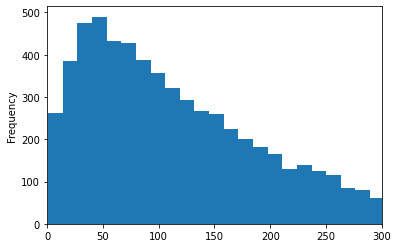

In [37]:
import matplotlib.pyplot as plt
supplier_transfers["requestingPracticeAsid"].value_counts().plot.hist(bins=500)
plt.gca().set_xlim([0,300])
    

In [39]:
supplier_transfers["Transfer Failed"].mean()


0.040860412906554386

(0.0, 300.0)

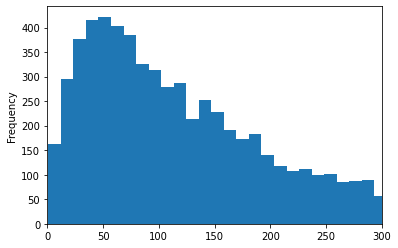

In [43]:
supplier_transfers["sendingPracticeAsid"].value_counts().plot.hist(bins=500)
plt.gca().set_xlim([0,300])

(0.0, 0.2)

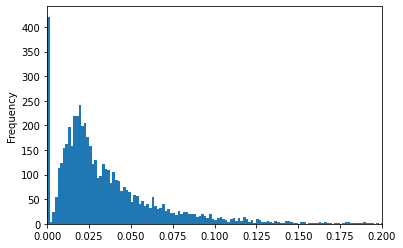

In [62]:
request_by_practice = supplier_transfers.groupby("requestingPracticeAsid").agg({"Transfer Failed":["count","mean"]})["Transfer Failed"]
request_by_practice.loc[request_by_practice["count"]>40, "mean"].plot.hist(bins=500)
plt.gca().set_xlim([0,0.2])


(0.0, 0.2)

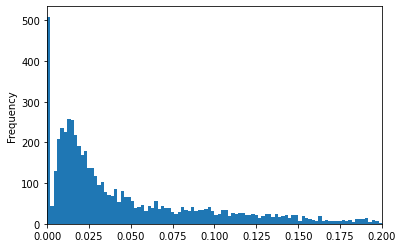

In [63]:
request_by_practice = supplier_transfers.groupby("sendingPracticeAsid").agg({"Transfer Failed":["count","mean"]})["Transfer Failed"]
request_by_practice.loc[request_by_practice["count"]>40, "mean"].plot.hist(bins=500)
plt.gca().set_xlim([0,0.2])